In [1]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/4211_Project/MvTec/bottle/'  

#path = '/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Dense, UpSampling2D, ZeroPadding2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import Model
from keras.optimizers import Adam#, RMSprop
import os
import random
import numpy as np
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import cv2

Using TensorFlow backend.


### Data check - Print raw sample image 

Raw image dimension: 
(900, 900, 3)


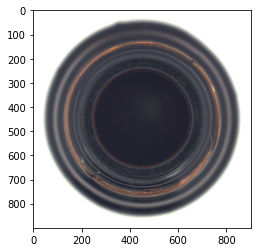

In [3]:
sample_raw = imread(path+'train/good/000.png')
plt.imshow(sample_raw)
print("Raw image dimension: ")
print(sample_raw.shape)

### Define image size and paths for preprocessing

In [0]:
IMG_H, IMG_W, IMG_C = 227,227,3

TRAIN_PATH = path+'train/good/'
train_ids = next(os.walk(TRAIN_PATH))[2]

TEST_PATH = path+'test/'
test_folders = next(os.walk(TEST_PATH))[1]

MASK_PATH = path+'ground_truth/'
mask_folders = test_folders.copy()
mask_folders.remove('good')

### Preprocessing 
- Load images from local file
- Resize images to 227 x 227

In [5]:
X_color, y_bad_color, y_good_color, mask = [],[],[],[]

for id in train_ids:
    path = TRAIN_PATH + id
    img = imread(path)
    img = resize(img, (IMG_H, IMG_W), mode='constant', preserve_range=True)
    X_color.append(img)

for folder in test_folders:
    folder_path = TEST_PATH+folder
    for id in sorted(next(os.walk(folder_path))[2]):
        img = imread(folder_path+'/'+id)
        img = resize(img, (IMG_H, IMG_W), mode='constant', preserve_range=True)
        if folder == 'good':
            y_good_color.append(img)
        else:
            y_bad_color.append(img)

for folder in mask_folders:
    folder_path = MASK_PATH+folder
    for id in sorted(next(os.walk(folder_path))[2]):
        img = imread(folder_path+'/'+id)
        img = resize(img, (IMG_H, IMG_W), mode='constant', preserve_range=True)
        mask.append(img)

X_color = np.asarray(X_color)
y_good_color = np.asarray(y_good_color)
y_bad_color = np.asarray(y_bad_color)
mask = np.asarray(mask)

print("Training data Sanity check: ", np.shape(X_color))
print("Normal testing data Sanity check: ",np.shape(y_good_color))
print("Anomalous testing data Sanity check: ",np.shape(y_bad_color))
print("Anomaly masks for testing Sanity check: ",np.shape(mask))

Training data Sanity check:  (212, 227, 227, 3)
Normal testing data Sanity check:  (24, 227, 227, 3)
Anomalous testing data Sanity check:  (63, 227, 227, 3)
Anomaly masks for testing Sanity check:  (63, 227, 227)


In [0]:
# Helper function for changing color images to grayscale

def to_grayscale(imgs):
    imgs_gray = np.zeros(imgs.shape[:-1])
    for i in range(len(imgs)): 
        imgs_gray[i] = cv2.cvtColor(imgs[i], cv2.COLOR_BGR2GRAY)
    imgs_gray = np.stack((imgs_gray,imgs_gray,imgs_gray), axis=-1)
    return imgs_gray

### Preprocessing 
- SSIM Loss operates on grayscale; change color images to grayscale
- Normalize (0-225) images to (0-1) for efficient training

In [0]:
X_color = np.asarray(X_color)
y_good_color = np.asarray(y_good_color)
y_bad_color = np.asarray(y_bad_color)
mask = np.asarray(mask)

X=to_grayscale(X_color.astype('uint8'))
y_bad=to_grayscale(y_bad_color.astype('uint8'))
y_good=to_grayscale(y_good_color.astype('uint8'))

X = X.astype('float32') / 255.0 
y_good = y_good.astype('float32') / 255.0 
y_bad = y_bad.astype('float32') / 255.0 

### Data check - Print processed sample image

Processed image dimension: 
(227, 227, 3)


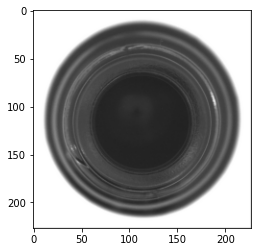

In [8]:
sample_processed = X[0]
plt.imshow(sample_processed)
print("Processed image dimension: ")
print(sample_processed.shape)

### Architecture
- Enoder: Alex-Net without the dense layers 
- Decode: Reversed version of the encoder

In [0]:
inputs = Input((IMG_H, IMG_W, IMG_C))
#inputs = Lambda(lambda x:x/255)(inputs)

#-------------------Contraction-----------------------

c1 = Conv2D(96, (11, 11), strides=4 , activation='relu', padding='valid')(inputs)
m1 = MaxPooling2D((3,3), strides=2)(c1)

c2 = ZeroPadding2D(padding=(2,2))(m1)
c2 = Conv2D(256, (5, 5), strides=1, activation='relu', padding='valid')(c2)
m2 = MaxPooling2D((3,3), strides=2)(c2)

c3 = ZeroPadding2D(padding=(1,1))(m2)
c3 = Conv2D(384, (3, 3), strides=1, activation='relu', padding='valid')(c3)

c4 = ZeroPadding2D(padding=(1,1))(c3)
c4 = Conv2D(384, (3, 3), strides=1, activation='relu', padding='valid')(c4)

c5 = ZeroPadding2D(padding=(1,1))(c4)
c5 = Conv2D(256, (3, 3), strides=1, activation='relu', padding='valid')(c5)
m5 = MaxPooling2D((3,3), strides=2)(c5)

#---------------------Expansion------------------------

em6 = Conv2DTranspose(256, (3, 3), strides=2)(m5)
e6 = Conv2D(256, (3, 3), strides=1, activation='relu', padding='valid')(em6)
e6 = ZeroPadding2D(padding=(1,1))(e6)
#e6 = Average()([e6, c5])

e7 = Conv2D(384, (3, 3), strides=1, activation='relu', padding='valid')(e6)
e7 = ZeroPadding2D(padding=(1,1))(e7)
# e7 = Average()([e7, c4])

e8 = Conv2D(384, (3, 3), strides=1, activation='relu', padding='valid')(e7)
e8 = ZeroPadding2D(padding=(1,1))(e8)

em9 = Conv2DTranspose(256, (3, 3), strides=2)(e8)
e9 = Conv2D(256, (5, 5), strides=1, activation='relu', padding='valid')(em9)
e9 = ZeroPadding2D(padding=(2,2))(e9)

em10 = Conv2DTranspose(96, (3, 3), strides=2)(e9)

e10 = Conv2DTranspose(96, (11, 11), strides=4)(em10)
e10 = Conv2D(96, (11, 11), strides=4 , activation='relu', padding='valid')(e10)
e10 = Conv2DTranspose(96, (11, 11), strides=4)(e10)
outputs = Conv2D(3, (1, 1), activation='sigmoid')(e10)

model = Model(inputs=[inputs], outputs=[outputs])

In [0]:
# Custom SSIM Loss to be used for training
def SSIMLoss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [11]:
optimizer = Adam(lr=5e-4)
model.compile(optimizer=optimizer, loss=SSIMLoss)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 227, 227, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 31, 31, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 15, 15, 256)       0   

### Data Augmentation
- Horizontally flipped training data set
- Vertical flipped training data set

Directly concatenated to original training data set and shuffled

In [12]:
import imgaug.augmenters as iaa

hflip = iaa.Fliplr(1)
hflip_aug = hflip(images=X)

vflip = iaa.Flipud(1)
vflip_aug = vflip(images=X)

X_aug = np.concatenate((X, hflip_aug, vflip_aug)) 
np.random.shuffle(X_aug)

print('Augemented Data set sanity check:', X_aug.shape)

Augemented Data set sanity check: (636, 227, 227, 3)


### Input Handicaps
- Add per-image Gaussian noise of Normal(0 , 0.1) to each training image 
- Introduce block cutout of size 20% of original image at random location in each training image

In [0]:
def handicap(imgs, add_noise=False, apply_cutout=False):
    if add_noise:
        noise = iaa.AdditiveGaussianNoise(scale = 0.1)
        imgs = noise(images = imgs)
        print("Gaussian noise ON")

    if apply_cutout:
        cutout = iaa.Cutout(fill_mode = 'constant', size = 0.2, cval = 0)
        imgs = cutout(images = imgs)
        print("Block cutout ON")

    print("Sample:")
    plt.imshow(imgs[0])

#X_aug_handicapped = handicap(X_aug, add_noise = True, apply_cutout=False)

### Training the model


In [14]:
callbacks = [
    EarlyStopping(patience = 10, monitor = 'val_loss'),
    ModelCheckpoint('Anomaly_Detect_bottle.h5', verbose=1, save_best_only = True)
]

#history = model.fit(X_aug_handicapped,X_aug, validation_split = 0.05, batch_size = 8, epochs = 100 ,callbacks=callbacks)
history = model.fit(X_aug,X_aug, validation_split = 0.05, batch_size = 8, epochs = 150 ,callbacks=callbacks)

Train on 604 samples, validate on 32 samples
Epoch 1/150
604/604 [==============================] - 18s 30ms/step - loss: 0.5307 - val_loss: 0.4459

Epoch 00001: val_loss improved from inf to 0.44591, saving model to Anomaly_Detect_bottle.h5
Epoch 2/150
604/604 [==============================] - 11s 18ms/step - loss: 0.3930 - val_loss: 0.3232

Epoch 00002: val_loss improved from 0.44591 to 0.32321, saving model to Anomaly_Detect_bottle.h5
Epoch 3/150
604/604 [==============================] - 11s 18ms/step - loss: 0.2740 - val_loss: 0.2447

Epoch 00003: val_loss improved from 0.32321 to 0.24469, saving model to Anomaly_Detect_bottle.h5
Epoch 4/150
604/604 [==============================] - 11s 18ms/step - loss: 0.2190 - val_loss: 0.1995

Epoch 00004: val_loss improved from 0.24469 to 0.19954, saving model to Anomaly_Detect_bottle.h5
Epoch 5/150
604/604 [==============================] - 11s 18ms/step - loss: 0.1960 - val_loss: 0.1791

Epoch 00005: val_loss improved from 0.19954 to 0.17

### Plot training and validation losses

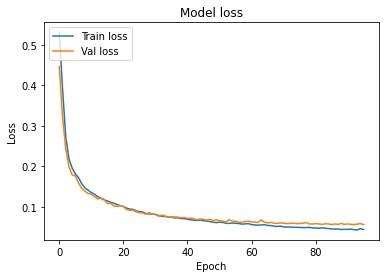

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], loc='upper left')
plt.show()

### Predict reconstructions of the data 
- `pred_train` : predicted reconstructions of traning data set
- `pred_test_good` : predicted reconstructions of non-anomalous test data set
- `pred_test_bad` : predicted reconstructions![alt text](https://) of anomalous test data set

In [16]:
preds_train = model.predict(X, verbose=1)
preds_test_good = model.predict(y_good, verbose=1)
preds_test_bad = model.predict(y_bad, verbose=1)

63/63 [==============================] - 1s 13ms/step


In [0]:
#Helper function for printing two images side-by-side
def print_two_imgs(left_img, right_img,left_label='', right_label=''):
    f = plt.figure()
    left_fig = f.add_subplot(1,2, 1)
    left_fig.set_title(left_label)
    plt.imshow(left_img)

    right_fig = f.add_subplot(1,2, 2)
    right_fig.set_title(right_label)
    plt.imshow(right_img)

### Compare original and reconstucted sample image in training set


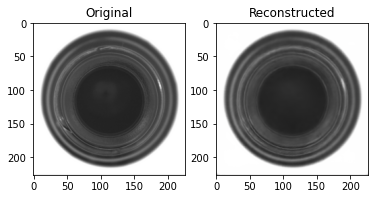

In [18]:
print_two_imgs(X[0],preds_train[0],'Original','Reconstructed')

### Helper functions for visualizing task results

In [0]:
from skimage.measure import compare_ssim

# Generates and returns SSIM diff. score and diff. image between the original and reconstructed
def generate_score_and_mask_ssim(original, reconstructed):
    original=np.mean(original, axis=-1)
    reconstructed = np.mean(reconstructed,axis=-1)

    (ssim_score, ssim_diff_img) = compare_ssim(original, reconstructed, full=True)
    return 1-ssim_score, 1-ssim_diff_img


# Generates and returns L2 diff. score and diff. image between the original and reconstructed
def generate_score_and_mask_l2(original, reconstructed):
    original=np.mean(original, axis=-1)
    reconstructed = np.mean(reconstructed,axis=-1)
    
    L2_diff_img = (original-reconstructed)**2
    L2_score = np.mean(L2_diff_img)
    return L2_score, L2_diff_img


# Helper function for printing subplots of images/mask/diff. images
def compare_img_and_masks(original, reconstructed, ssim_diff_image, l2_diff_image, true_mask = None):
    f = plt.figure(figsize=(15,15))

    ori = f.add_subplot(1,5,1)
    ori.set_title("Original")
    plt.imshow(original)

    recon = f.add_subplot(1,5,2)
    recon.set_title("Reconstructed")
    plt.imshow(reconstructed)

    if true_mask is not None:
        t_mask = f.add_subplot(1,5,3)
        t_mask.set_title("Ground-truth Mask")
        plt.imshow(true_mask) 

    ssim_diff = f.add_subplot(1,5,4)
    ssim_diff.set_title("SSIM diff. image")
    plt.imshow(ssim_diff_image)

    l2_diff = f.add_subplot(1,5,5)
    l2_diff.set_title("L2 diff. image")
    plt.imshow(l2_diff_image)

    plt.tight_layout()


# Jointly normalizes data1 and data2 to range of 0-1
def normalize(data1, data2):
    global_max = max(max(data1), max(data2))
    global_min = min(min(data1), min(data2))
    return (data1 - global_min) / (global_max - global_min), (data2 - global_min) / (global_max - global_min)


### Print 10 sample visuals of each **anomalous** test data set and collect difference scores

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  


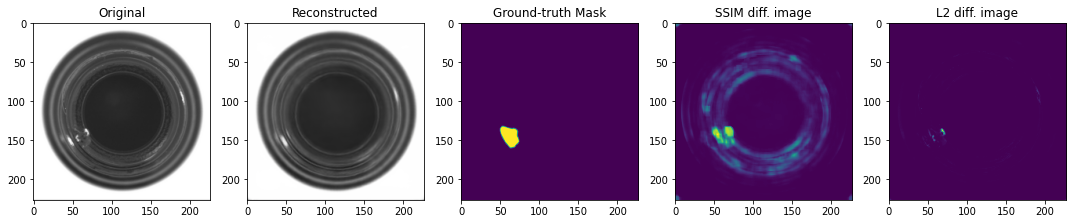

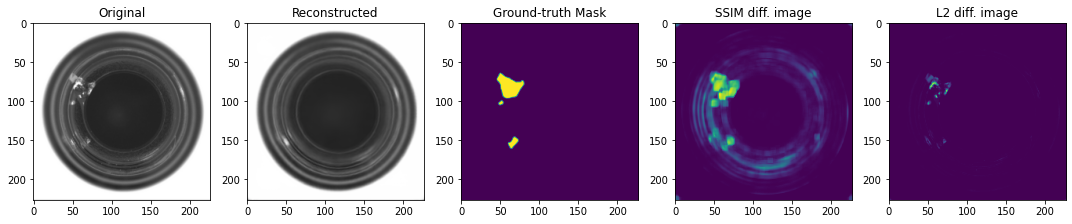

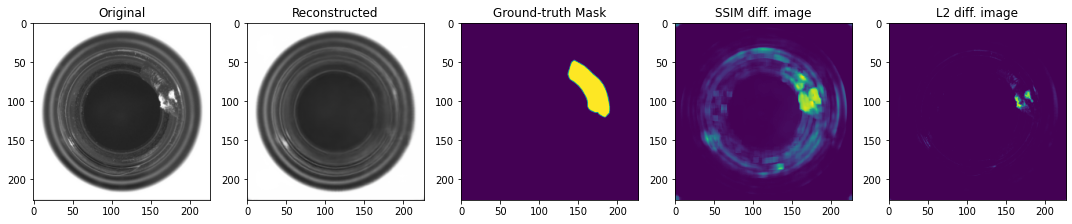

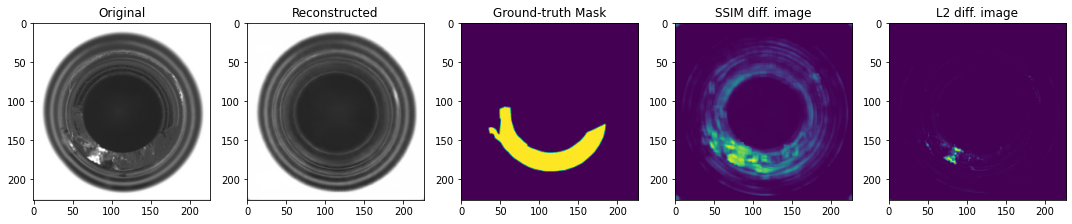

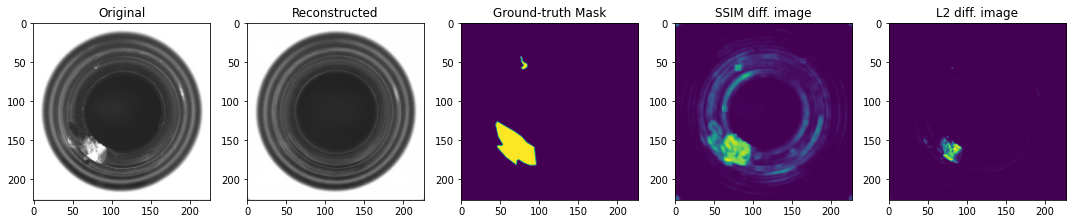

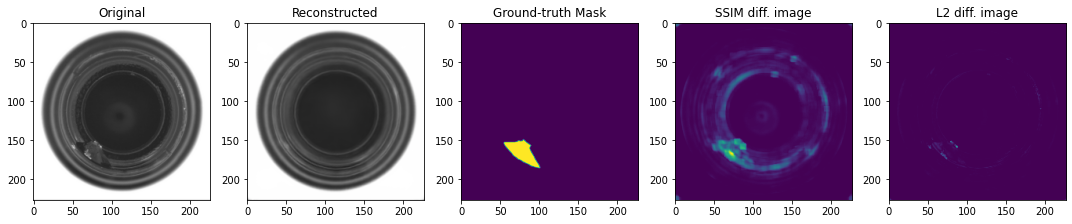

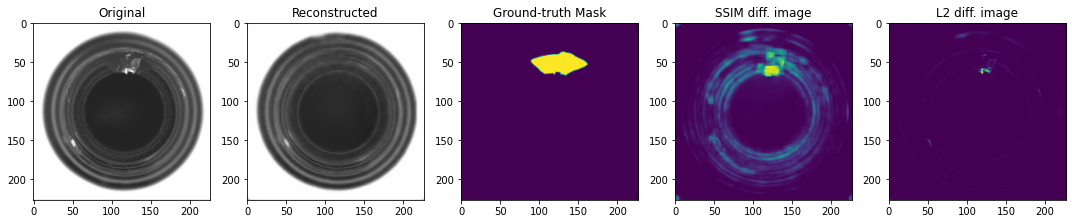

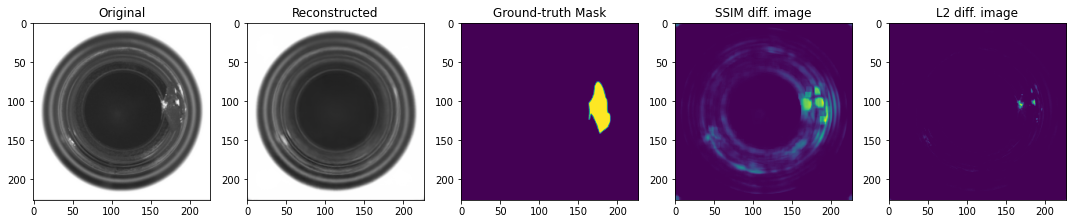

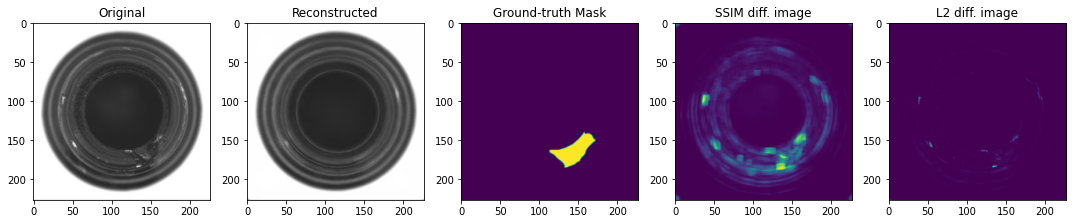

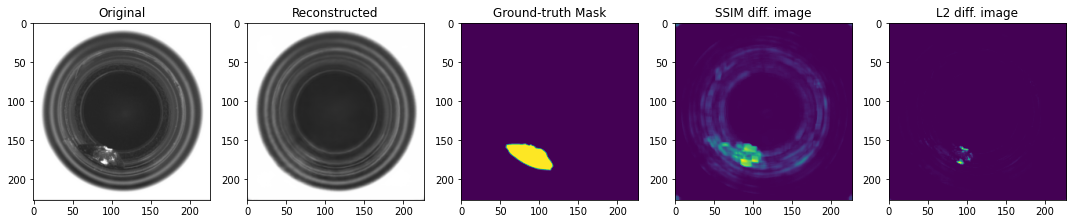

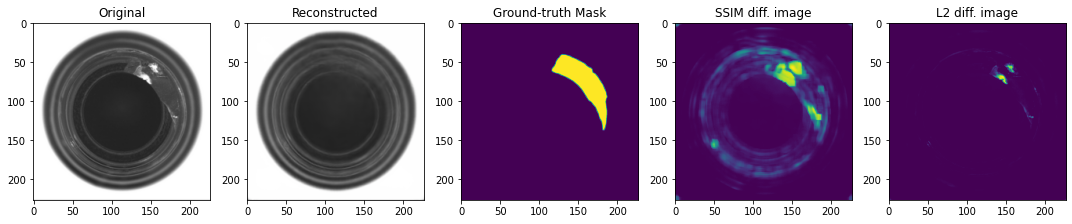

In [20]:
bad_test_l2_scores = []
bad_test_ssim_scores = []

for i in range(len(y_bad)):
    original = y_bad[i]
    reconstructed = preds_test_bad[i]

    ssim_score, ssim_diff = generate_score_and_mask_ssim(original, reconstructed)
    l2_score, l2_diff = generate_score_and_mask_l2(original, reconstructed)

    bad_test_ssim_scores.append(ssim_score)
    bad_test_l2_scores.append(l2_score)
    
    if i <= 10:
      compare_img_and_masks(original, reconstructed, ssim_diff, l2_diff, mask[i])

### Print 10 sample visuals of each **non-anomalous** test data set and collect difference scores

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  


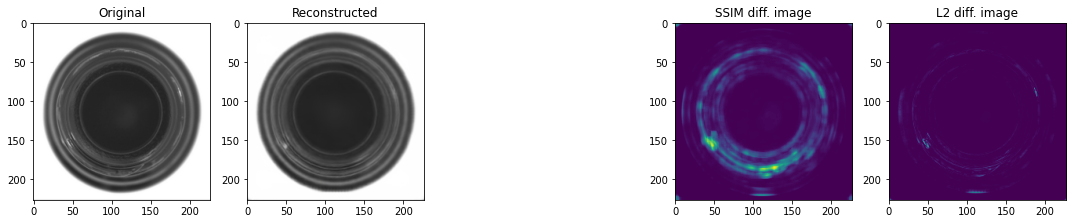

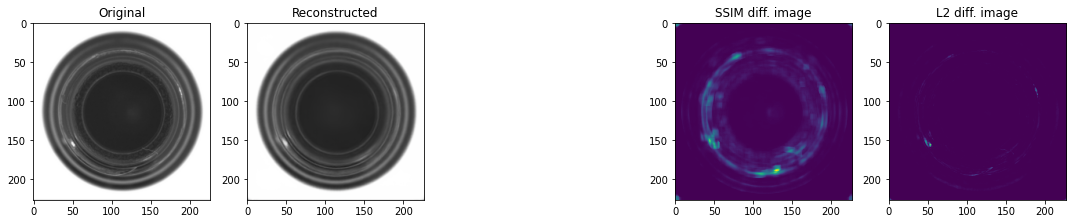

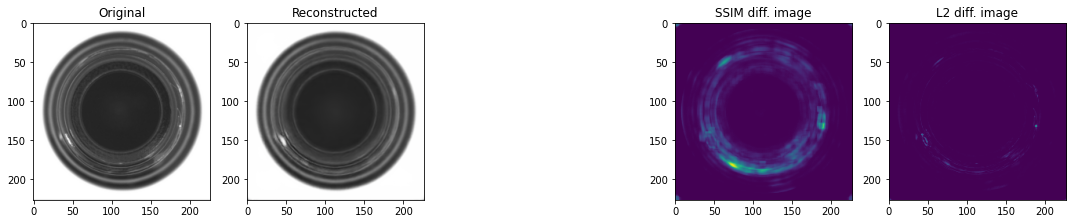

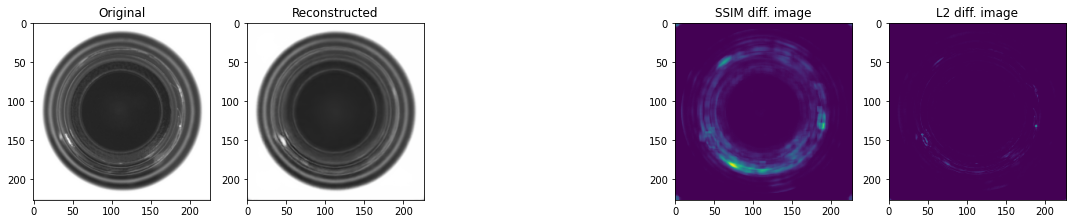

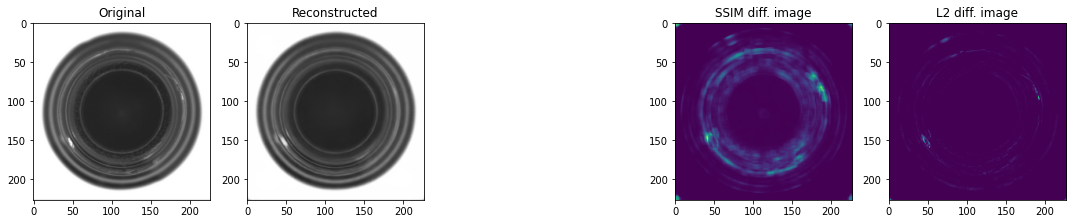

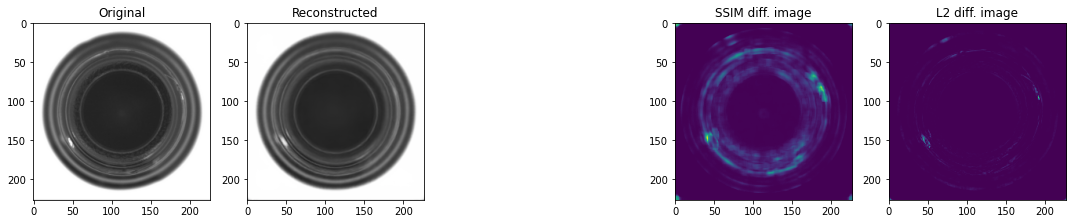

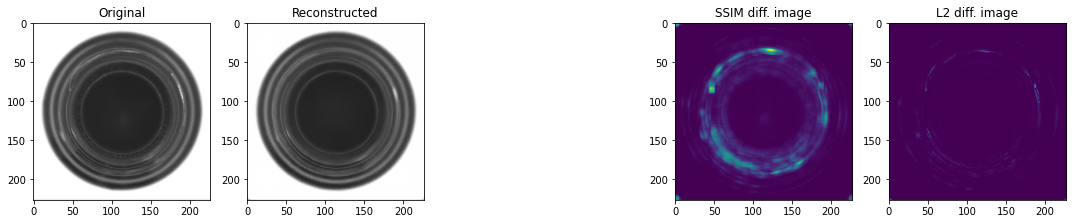

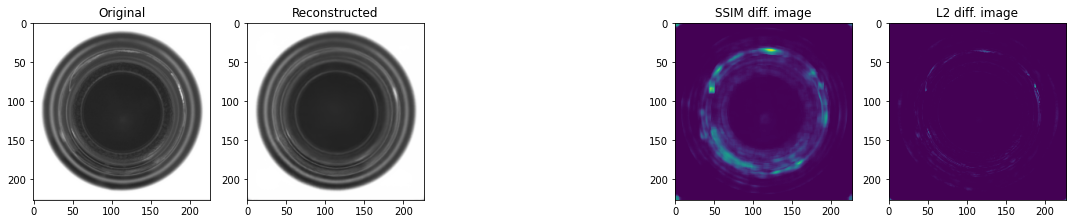

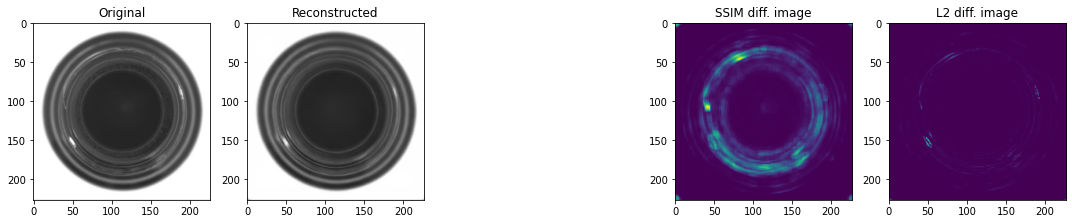

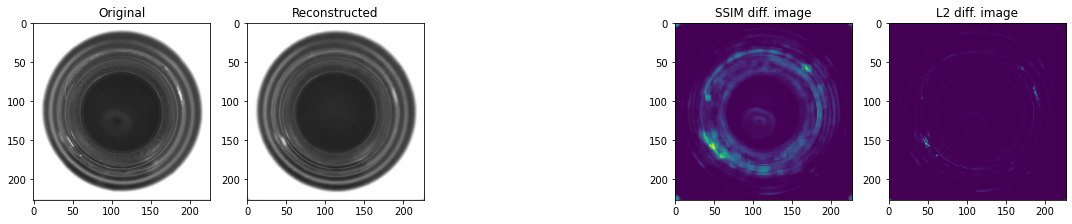

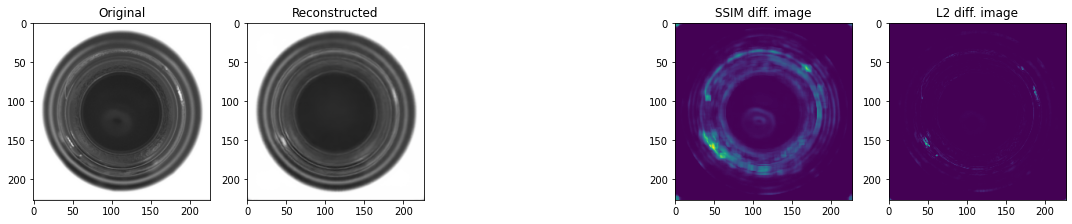

In [21]:
good_test_l2_scores = []
good_test_ssim_scores = []

for i in range(len(y_good)):
    original = y_good[i]
    reconstructed = preds_test_good[i]

    ssim_score, ssim_diff = generate_score_and_mask_ssim(original, reconstructed)
    l2_score, l2_diff = generate_score_and_mask_l2(original, reconstructed)

    good_test_ssim_scores.append(ssim_score)
    good_test_l2_scores.append(l2_score)

    if i <= 10:
      compare_img_and_masks(original, reconstructed, ssim_diff, l2_diff, None)

### Normalize the scores of anomlaous and non anomalous testing data set to a range of 0~1

In [0]:
good_test_l2_scores_norm, bad_test_l2_scores_norm = normalize(good_test_l2_scores, bad_test_l2_scores)
good_test_ssim_scores_norm, bad_test_ssim_scores_norm = normalize(good_test_ssim_scores, bad_test_ssim_scores)

## Evaluation
### Scatter plots of L2 and SSIM reconstruction difference scores of anomalous and non-anomalous testing images

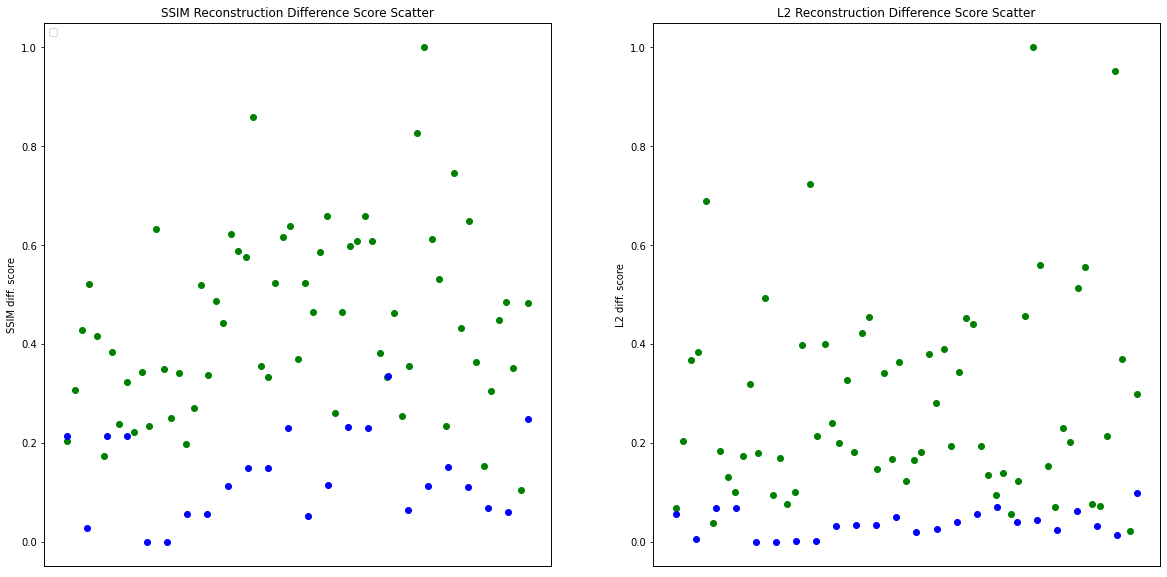

In [23]:
fig, ax= plt.subplots(1,2,figsize=(20,10)) #ssim

ax[0].set_title("SSIM Reconstruction Difference Score Scatter")
ax[0].set_ylabel('SSIM diff. score')
ax[0].set_xlabel('Test images')
ax[0].legend(['Train loss', 'Val loss'], loc='upper left')
ax[0].scatter(range(1,len(bad_test_ssim_scores_norm)+1), bad_test_ssim_scores_norm, c='green')
ax0 = ax[0].twiny()
ax0.scatter(range(1,len(good_test_ssim_scores_norm)+1), good_test_ssim_scores_norm, c='blue')
ax[0].axes.get_xaxis().set_visible(False)
ax0.axes.get_xaxis().set_visible(False)

ax[1].set_title("L2 Reconstruction Difference Score Scatter")
ax[1].set_ylabel('L2 diff. score')
ax[1].set_xlabel('Test images')
ax[1].scatter(range(1,len(bad_test_l2_scores_norm)+1), bad_test_l2_scores_norm, c='green')
ax1 = ax[1].twiny()
ax1.scatter(range(1,len(good_test_l2_scores_norm)+1), good_test_l2_scores_norm, c='blue')
ax[1].axes.get_xaxis().set_visible(False)
ax1.axes.get_xaxis().set_visible(False)
